In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import duckdb
connection = duckdb.connect()
import os
import datetime

# Collect pollution

In [2]:
mor_pol = pd.read_parquet('pollution_morelia.parquet').reset_index(drop=True)
mex_pol = pd.read_parquet('pollution_mex.parquet').reset_index(drop=True)
mor_pol['region'] = 'Morelia'
mex_pol['region'] = 'Mexico'

mor_pol = mor_pol.rename(columns={'Time': 'time', 'PM2.5': 'PM25', })
mex_pol = mex_pol.rename(columns={'Date': 'time', 'no': 'NO'})

idx = mex_pol.loc[mex_pol.time.str.contains('24:00'), 'time'].index
mex_pol.loc[idx, 'time'] = mex_pol.loc[idx, 'time'].apply(lambda x: x[:10])
mex_pol = mex_pol.astype({'time': 'datetime64[ns]'})
mex_pol.loc[idx, 'time'] += datetime.timedelta(days=1)
mex_pol[:25]

pollution = pd.concat([mor_pol, mex_pol])
pollution = pollution[list(filter(lambda x: 'flag' not in x, pollution.columns))]
pollution = pollution[pollution.isna().sum(axis=1) < 8].reset_index(drop=True).copy()
pollution = pollution.astype({'NO': np.float32, 'time': 'datetime64[ns]'})

In [3]:
pollution

time         O3         SO2    NO2          NO      CO  \
0     2015-02-09 15:00:00  10.020000   -0.700000   4.48    0.060000  -0.300   
1     2015-02-09 16:00:00   4.330000   -0.440000   0.78   -0.090000  -0.250   
2     2015-02-09 17:00:00  36.369999    0.650000   1.11   -0.080000   0.200   
3     2015-02-09 18:00:00  45.439999  164.759995  35.52  206.830002  14.170   
4     2015-02-09 19:00:00  38.560001    0.750000   2.03   -0.220000   0.200   
...                   ...        ...         ...    ...         ...     ...   
53791 2019-09-08 20:00:00  34.970000    1.216000  12.13    1.141000   0.269   
53792 2019-09-08 21:00:00  29.880000    1.187000  13.77    0.933000   0.309   
53793 2019-09-08 22:00:00  27.990000    1.298000  13.72    1.054000   0.261   
53794 2019-09-08 23:00:00  24.940000    1.156000  13.78    1.012000   0.283   
53795 2019-09-09 00:00:00  23.350000    1.523000  13.15    0.952000   0.251   

       PM10   PM25   region    NOX  
0       NaN  12.92  Morelia    NaN  
1       NaN   5.41  Morelia    NaN  
2       NaN   7.58  Morelia    NaN  
3       NaN   5.74  Morelia    NaN  
4       NaN   5.10  Morelia    NaN  
...     ...    ...      ...    ...  
53791   NaN   0.00   Mexico  13.27  
53792   NaN   0.00   Mexico  14.70  
53793   NaN   0.00   Mexico  14.77  
53794   NaN   0.00   Mexico  14.79  
53795   NaN   0.00   Mexico  14.09  

[53796 rows x 10 columns]

In [11]:
s = '''
select 
    time,

    CASE when
        (
            (O3 > 0) or (O3 is NULL)
        )
        then O3 else NULL
        END as O3,
        
    CASE when
        (
            (SO2 > 0) or (SO2 is NULL)
        )
        then SO2 else NULL
        END as SO2,
        
    CASE when
        (
            (NO2 > 0) or (NO2 is NULL)
        )
        then NO2 else NULL
        END as NO2,
        
    CASE when
        (
            (NO > 0) or (NO is NULL)
        )
        then NO else NULL
        END as NO,
        
    CASE when
        (
            (CO > 0) or (CO is NULL)
        )
        then CO else NULL
        END as CO,
        
    CASE when
        (
            (PM10 > 0) or (PM10 is NULL)
        )
        then PM10 else NULL
        END as PM10,
        
    CASE when
        (
            (PM25 > 0) or (PM25 is NULL)
        )
        then PM25 else NULL
        END as PM25,
        
    CASE when
        (
            (NOX > 0) or (NOX is NULL)
        )
        then NOX else NULL
        END as NOX,

    region

from pollution
'''
pollution = connection.execute(s).df()

In [12]:
s = '''
with t1 as (
    select *,
    quantile_cont(O3, 0.95)     over (partition by region) as o3q95,
    quantile_cont(SO2, 0.95)    over (partition by region) as so2q95,
    quantile_cont(NO2, 0.95)    over (partition by region) as no2q95,
    quantile_cont(NO, 0.95)     over (partition by region) as noq95,
    quantile_cont(CO, 0.95)     over (partition by region) as coq95,
    quantile_cont(PM10, 0.95)   over (partition by region) as pm10q95,
    quantile_cont(PM25, 0.95)   over (partition by region) as pm25q95,
    quantile_cont(NOX, 0.95)    over (partition by region) as noxq95,

    quantile_cont(O3, 0.05)     over (partition by region) as o3q05,
    quantile_cont(SO2, 0.05)    over (partition by region) as so2q05,
    quantile_cont(NO2, 0.05)    over (partition by region) as no2q05,
    quantile_cont(NO, 0.05)     over (partition by region) as noq05,
    quantile_cont(CO, 0.05)     over (partition by region) as coq05,
    quantile_cont(PM10, 0.05)   over (partition by region) as pm10q05,
    quantile_cont(PM25, 0.05)   over (partition by region) as pm25q05,
    quantile_cont(NOX, 0.05)    over (partition by region) as noxq05,
    
    from pollution 
)

select 
    time,

    CASE when
        (
            (O3 between o3q05 and o3q95) or (O3 is NULL)
        )
        then O3 else NULL
        END as O3,
        
    CASE when
        (
            (SO2  between so2q05 and so2q95) or (SO2 is NULL)
        )
        then SO2 else NULL
        END as SO2,
        
    CASE when
        (
            (NO2  between no2q05 and no2q95) or (NO2 is NULL)
        )
        then NO2 else NULL
        END as NO2,
        
    CASE when
        (
            (NO  between noq05 and noq95) or (NO is NULL)
        )
        then NO else NULL
        END as NO,
        
    CASE when
        (
            (CO  between coq05 and coq95) or (CO is NULL)
        )
        then CO else NULL
        END as CO,
        
    CASE when
        (
            (PM10  between pm10q05 and pm10q95) or (PM10 is NULL)
        )
        then PM10 else NULL
        END as PM10,
        
    CASE when
        (
            (PM25  between pm25q05 and pm25q95) or (PM25 is NULL)
        )
        then PM25 else NULL
        END as PM25,
        
    CASE when
        (
            (NOX  between noxq05 and noxq95) or (NOX is NULL)
        )
        then NOX else NULL
        END as NOX,

    region

from t1
'''
pollution = connection.execute(s).df()
pollution.head()

time     O3    SO2    NO2     no     CO  PM10  PM25    NOX  \
0 2019-05-19 21:00:00  55.79  1.382  13.21    NaN  0.409   NaN  40.0  13.70   
1 2019-05-19 22:00:00  45.32  1.413  15.17  0.632  0.442   NaN  38.0  15.80   
2 2019-05-19 23:00:00  19.80  1.375  28.44  3.001  0.642   NaN  23.0  31.43   
3 2019-05-20 00:00:00   8.36  1.327  34.66  3.201  0.781   NaN  25.0  37.86   
4 2019-05-20 01:00:00  22.17  1.221  21.31  1.555  0.597   NaN  35.0  22.86   

   region  
0  Mexico  
1  Mexico  
2  Mexico  
3  Mexico  
4  Mexico

In [13]:
pollution.describe()

O3           SO2           NO2            no            CO  \
count  30737.000000  42387.000000  24339.000000  20502.000000  42899.000000   
mean      32.228508      1.082150      9.332462      3.520174      0.410089   
std       16.141615      1.082829      9.338415      6.401709      0.185520   
min        3.867000      0.110000      0.620000      0.030000      0.168000   
25%       19.969999      0.490000      2.700000      0.520000      0.270000   
50%       30.129999      0.840000      5.360000      1.470000      0.360000   
75%       42.710000      1.317000     12.570000      3.500000      0.500000   
max       89.900000     10.990000     42.700000     46.500000      1.175000   

               PM10          PM25          NOX  
count  38019.000000  23163.000000  7168.000000  
mean      21.507372     15.927629    29.278742  
std        9.891704      8.281724    16.471852  
min        5.450000      3.100000     8.900000  
25%       13.570000      9.510000    16.450000  
50%       20.000000     14.350000    24.675000  
75%       28.440001     21.000000    37.935000  
max       46.750000     45.000000    83.100000

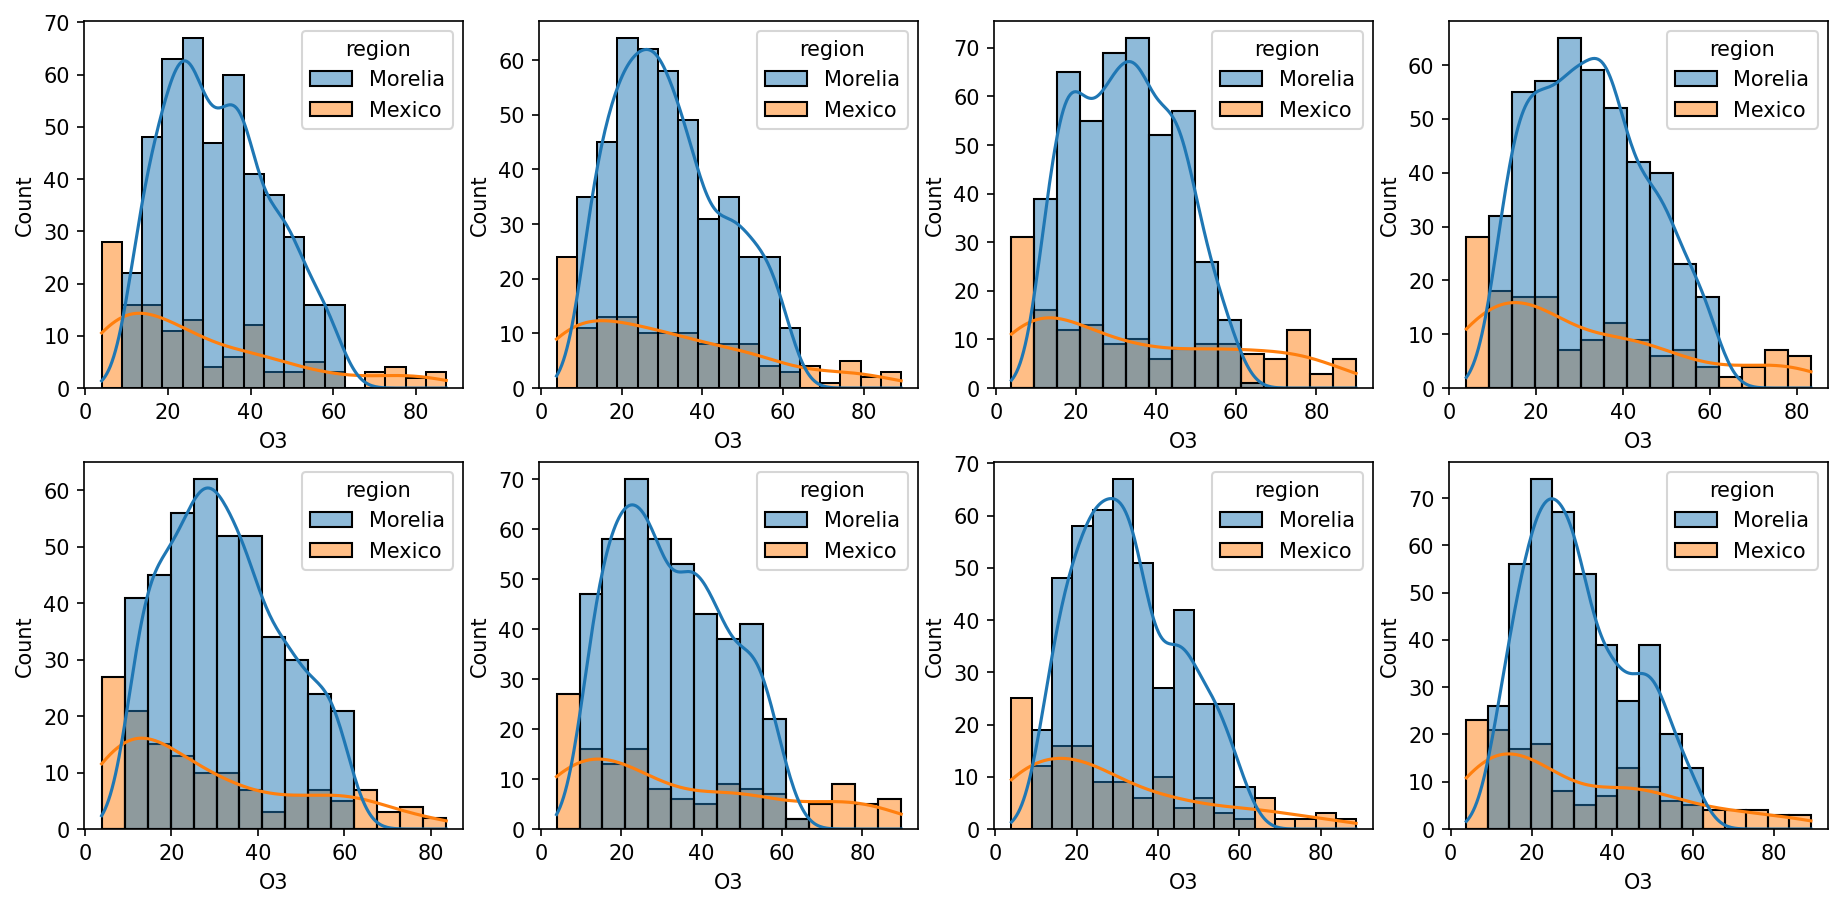

In [14]:
_, axs = plt.subplots(2, 4, dpi=150, figsize=(15, 7))
n = 0
for i in axs:
    for j in i:
        if n < 7:
            sns.histplot(data=pollution.sample(1000), x=pollution.columns[n+1], hue='region', ax=j, kde=True)
            # col = pollution.columns[n+1]
            # pollution[col].hist(ax=j, bins=100)
            # j.set_title(col)
            # n+=1

In [16]:
pollution.to_parquet('pollution.parquet')

# Concatinate

In [6]:
pollution = pd.read_parquet('pollution.parquet')
sql_command = '''
with df as (
    select 
        date_trunc('hour', TIMESTAMP) as time,
        Temp_Avg,
        region,
        RH_Avg,
        WSpeed_Avg,
        WDir_Avg,
        WDir_SD,
        Rain_Tot,
        Press_Avg,
        Rad_Avg,
        Visibility_Avg
    
    from read_parquet(['cleaned.parquet'])
    ),

t1 as (
        select 
        time,
        region, 
        avg(Temp_Avg) as temp,
        avg(RH_Avg) as rh,
        avg(WSpeed_Avg) as wspeed,
        avg(WDir_Avg) as wdir_avg,	
        avg(WDir_SD) as wdir_sd,
        avg(Rain_Tot) as rain,
        avg(Press_Avg) as press,
        avg(Rad_Avg) as rad,
        avg(Visibility_Avg) as vis

    from df
        group by time, region
    ),

t2 as (
    select * from t1
    join pollution p
    on t1.time = p.time and p.region = t1.region
)

select *, 
    date_part('hour', time) as hour, 
    date_part('week', time) as week,
    date_part('month', time) as month,
    dayname(time) as dayname,

    date_trunc('day', time) as time_day, 
    date_trunc('week', time) as time_week, 
    date_trunc('month', time) as time_month
from t2 order by time
'''

df = connection.execute(sql_command).df().drop(columns=['region:1', 'time:1'])
gases = ['O3', 'SO2', 'NO2', 'no', 'CO', 'PM10', 'PM25', 'NOX']
df['day_week_num'] = df.time.dt.dayofweek
df.head()

time   region  temp  rh  wspeed  wdir_avg  wdir_sd  rain  \
0 2015-08-09 00:00:00  Morelia   NaN NaN     NaN       NaN      NaN   NaN   
1 2015-08-09 01:00:00  Morelia   NaN NaN     NaN       NaN      NaN   NaN   
2 2015-08-09 02:00:00  Morelia   NaN NaN     NaN       NaN      NaN   NaN   
3 2015-08-09 03:00:00  Morelia   NaN NaN     NaN       NaN      NaN   NaN   
4 2015-08-09 04:00:00  Morelia   NaN NaN     NaN       NaN      NaN   NaN   

   press  rad  ...   PM25  NOX  hour  week  month  dayname   time_day  \
0    NaN  NaN  ...   5.72  NaN     0    32      8   Sunday 2015-08-09   
1    NaN  NaN  ...   7.22  NaN     1    32      8   Sunday 2015-08-09   
2    NaN  NaN  ...   4.76  NaN     2    32      8   Sunday 2015-08-09   
3    NaN  NaN  ...   7.08  NaN     3    32      8   Sunday 2015-08-09   
4    NaN  NaN  ...  12.54  NaN     4    32      8   Sunday 2015-08-09   

   time_week  time_month  day_week_num  
0 2015-08-03  2015-08-01             6  
1 2015-08-03  2015-08-01             6  
2 2015-08-03  2015-08-01             6  
3 2015-08-03  2015-08-01             6  
4 2015-08-03  2015-08-01             6  

[5 rows x 27 columns]

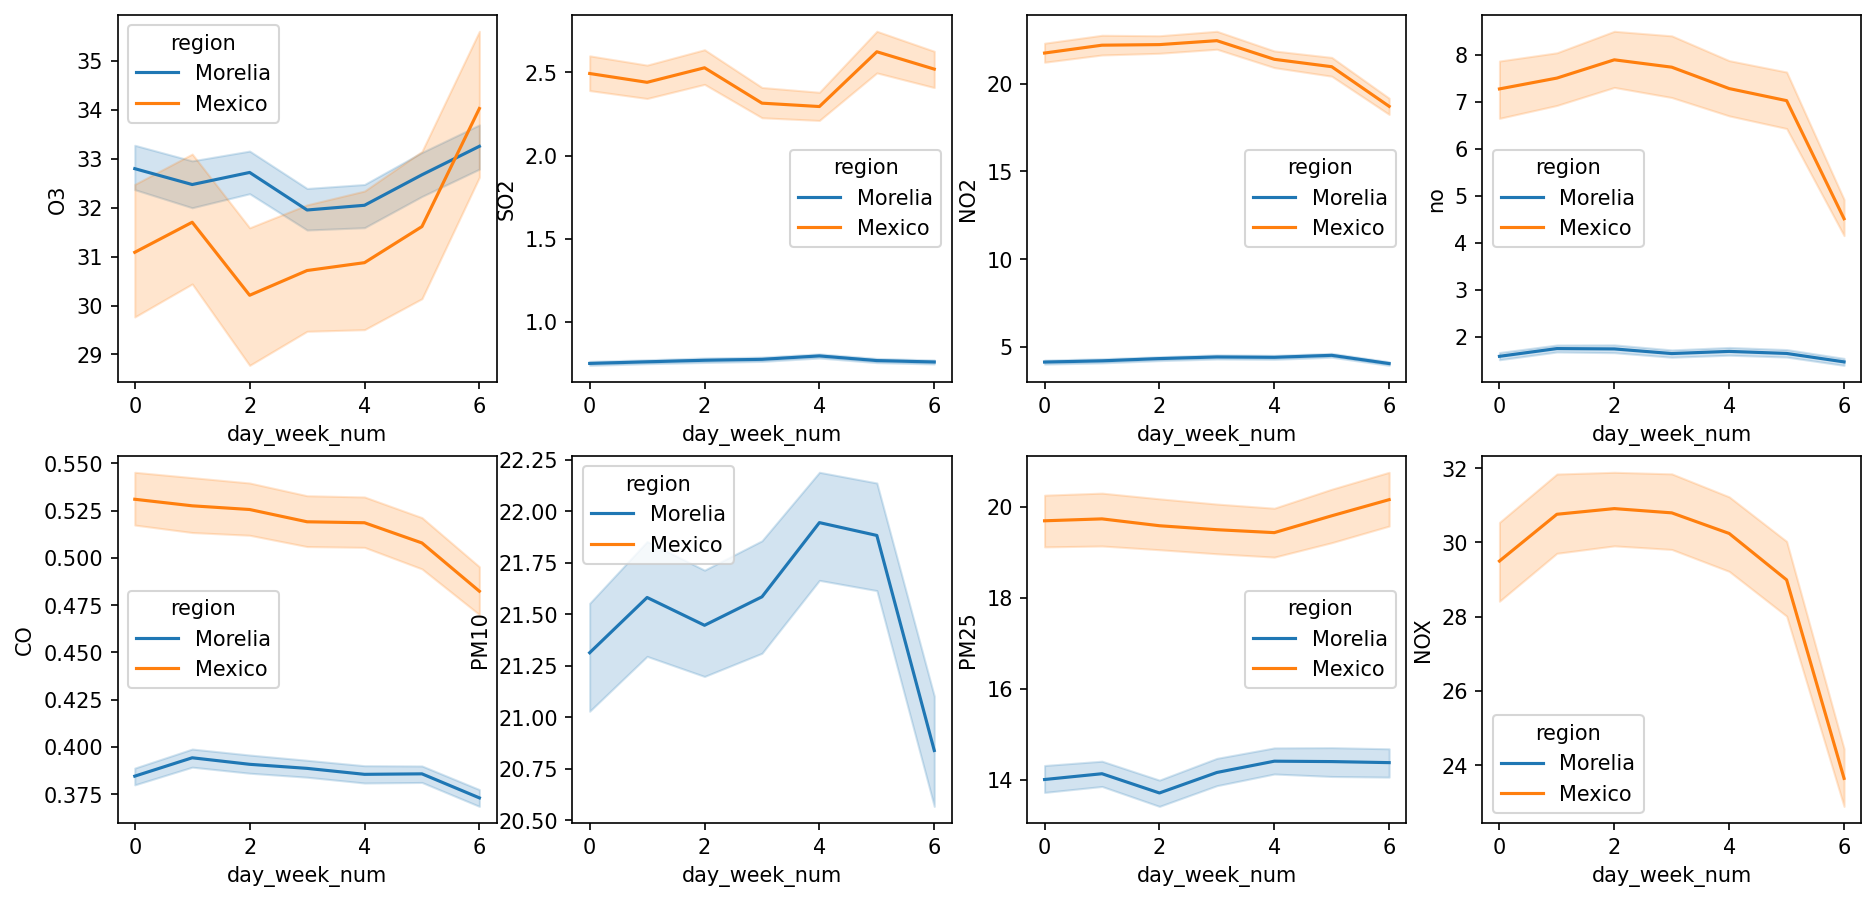

In [7]:
_, axs = plt.subplots(2, 4, figsize=(15, 7), dpi=150)
n = 0
for cnti, i in enumerate(axs):
    for cntj, j in enumerate(i):
        gas = gases[n]
        try:
            g = sns.lineplot(data=df, x='day_week_num', y=gas, ax=j, hue='region')
        except KeyError:
            pass
        n += 1

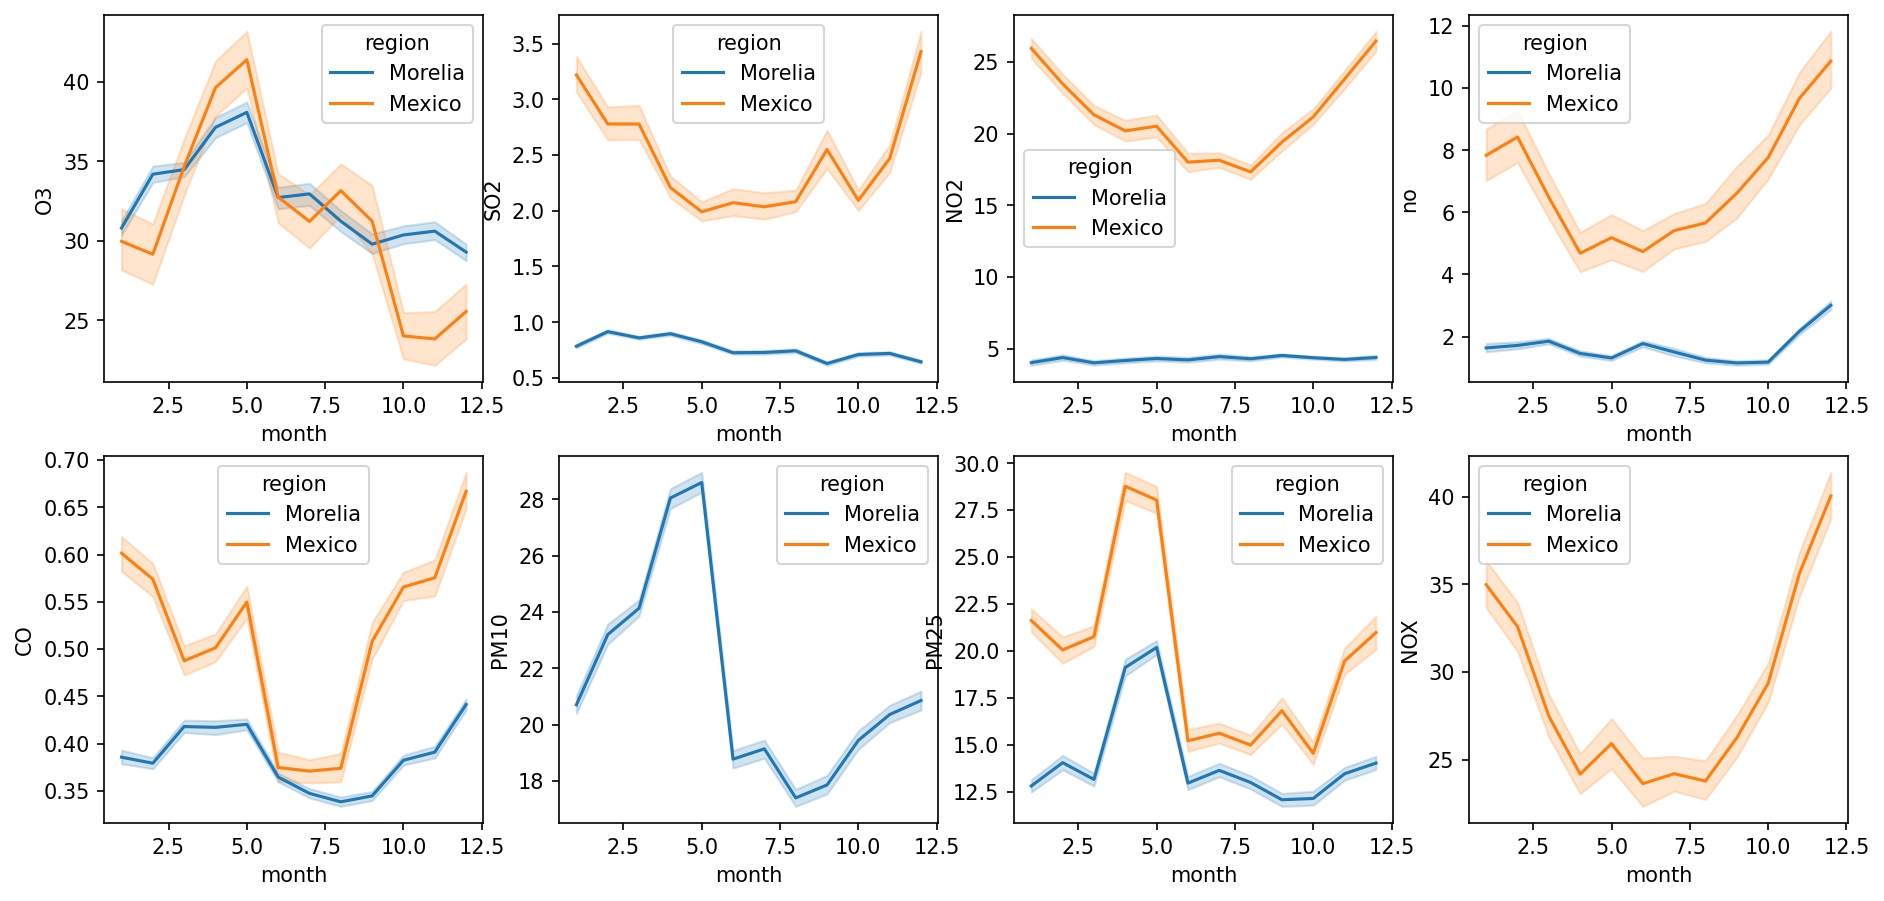

In [8]:
_, axs = plt.subplots(2, 4, figsize=(15, 7), dpi=150)
n = 0
for cnti, i in enumerate(axs):
    for cntj, j in enumerate(i):
        gas = gases[n]
        try:
            g = sns.lineplot(data=df, x='month', y=gas, ax=j, hue='region')
        except KeyError:
            pass
        n += 1

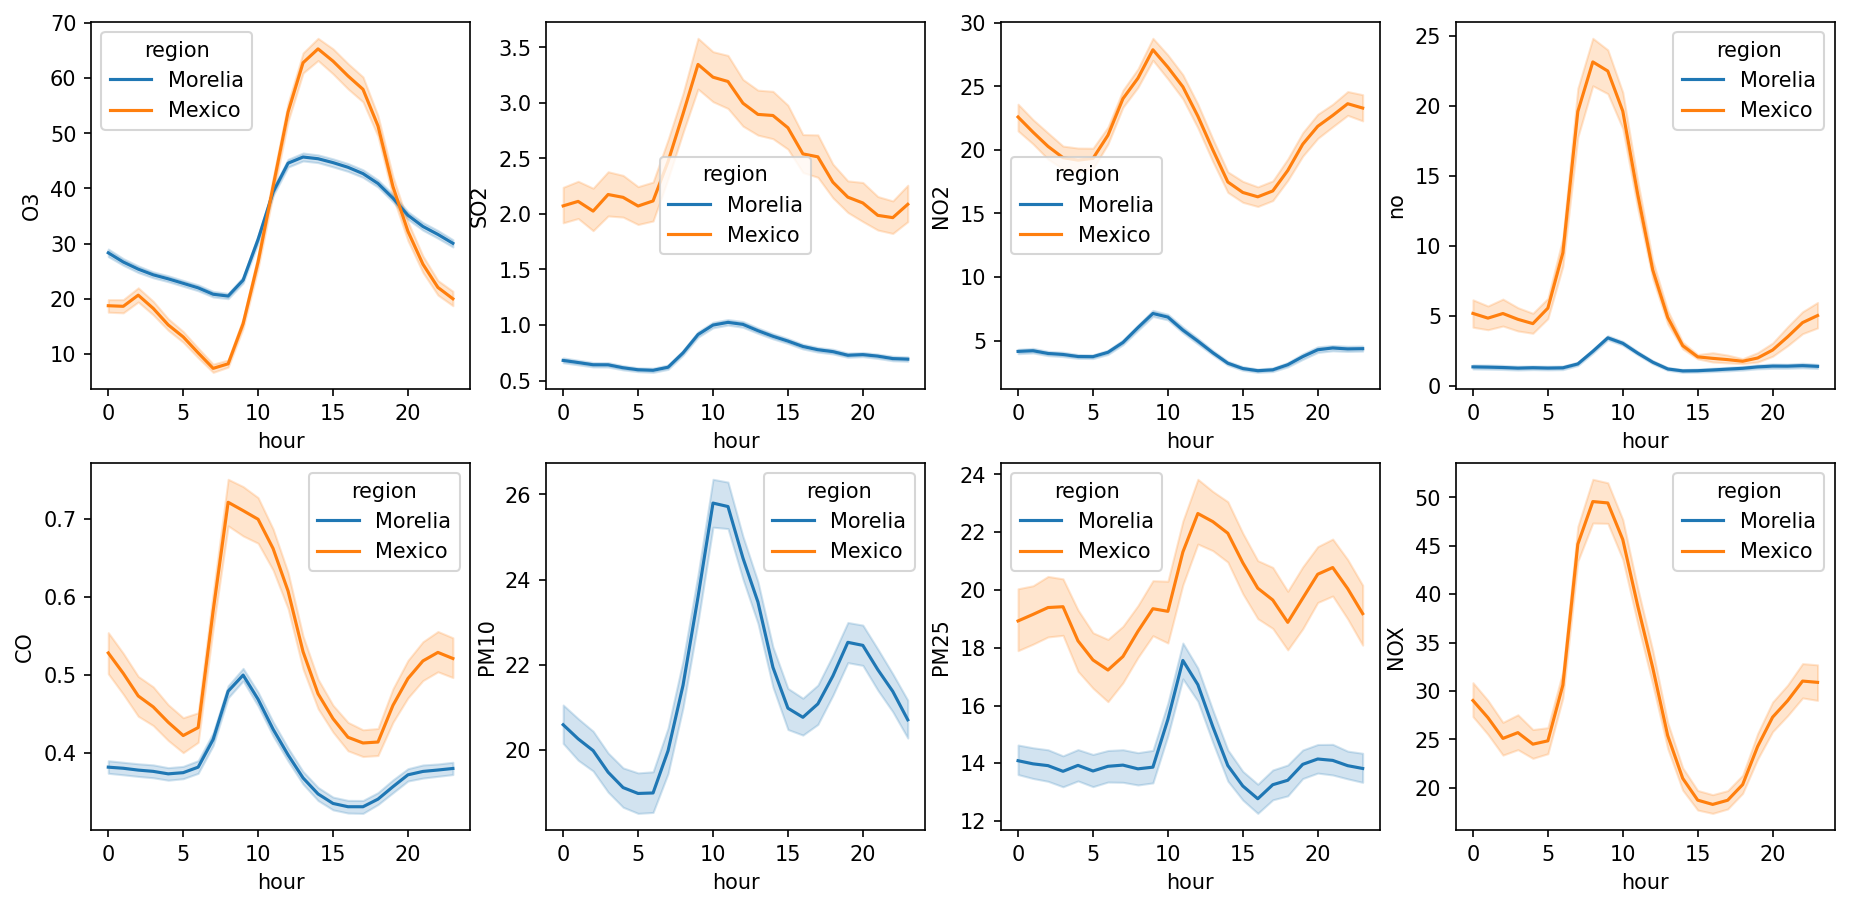

In [9]:
_, axs = plt.subplots(2, 4, figsize=(15, 7), dpi=150)
n = 0
for cnti, i in enumerate(axs):
    for cntj, j in enumerate(i):
        gas = gases[n]
        try:
            sns.lineplot(data=df, x='hour', y=gas, ax=j, hue='region')
        except KeyError:
            pass
        n += 1

In [10]:
gases

['O3', 'SO2', 'NO2', 'no', 'CO', 'PM10', 'PM25', 'NOX']

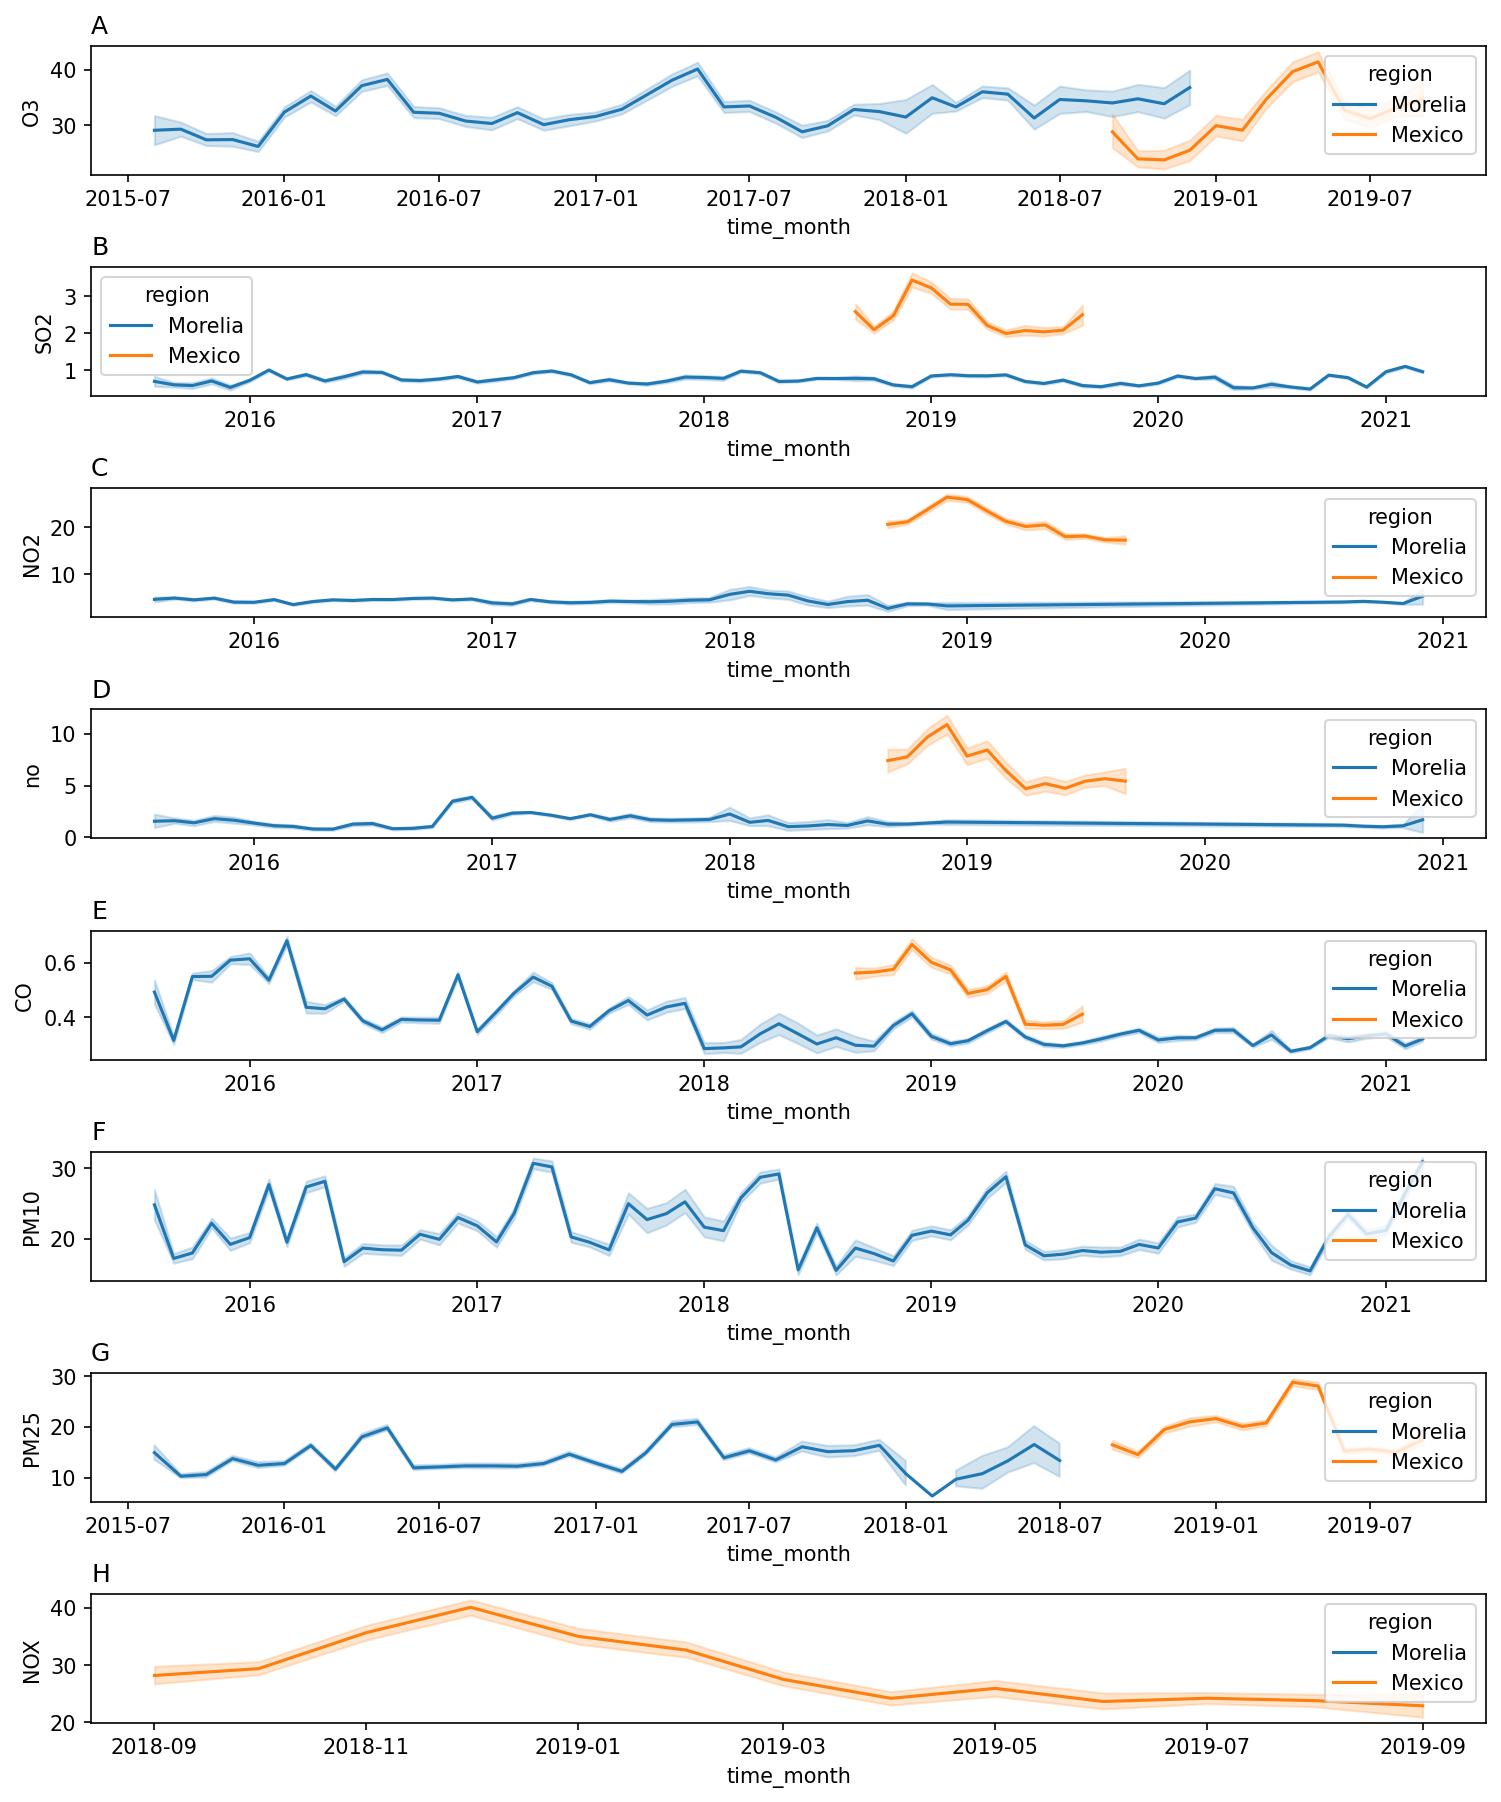

In [11]:
fig, axs = plt.subplots(8, 1, dpi=150, figsize=(12, 15))
sns.lineplot(data=df[df.time < '2020-01-01'], x='time_month', y=gases[0], hue='region', ax=axs[0])
for i in range(1, 8):
    sns.lineplot(data=df, x='time_month', y=gases[i], hue='region', ax=axs[i])

titles = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
for i in range(8):
    axs[i].set_title(titles[i], loc='left')
    box = axs[i].get_position()
    axs[i].set_position([box.x0, box.y0, box.width, box.height*0.7])

<AxesSubplot:xlabel='time_month', ylabel='SO2'>

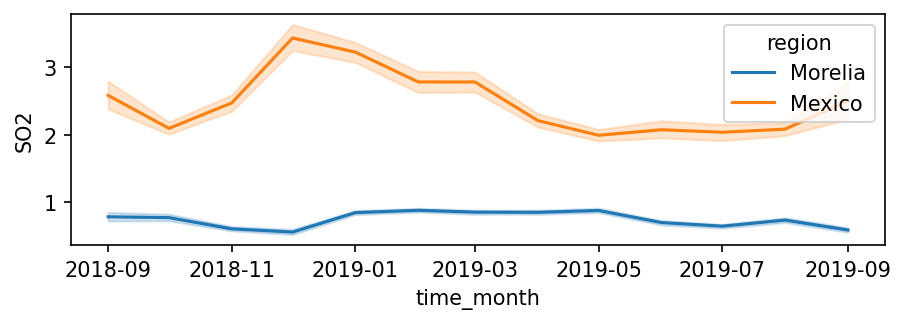

In [34]:
_, ax = plt.subplots(figsize=(7, 2), dpi=150)
sns.lineplot(data=df[df.time_month.between('2018-09-01', '2019-9-01')], x='time_month', y='SO2', hue='region', ax=ax)

C:\Users\Alex\AppData\Local\Temp\ipykernel_20560\601963093.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrM = df.corr()


<AxesSubplot:>

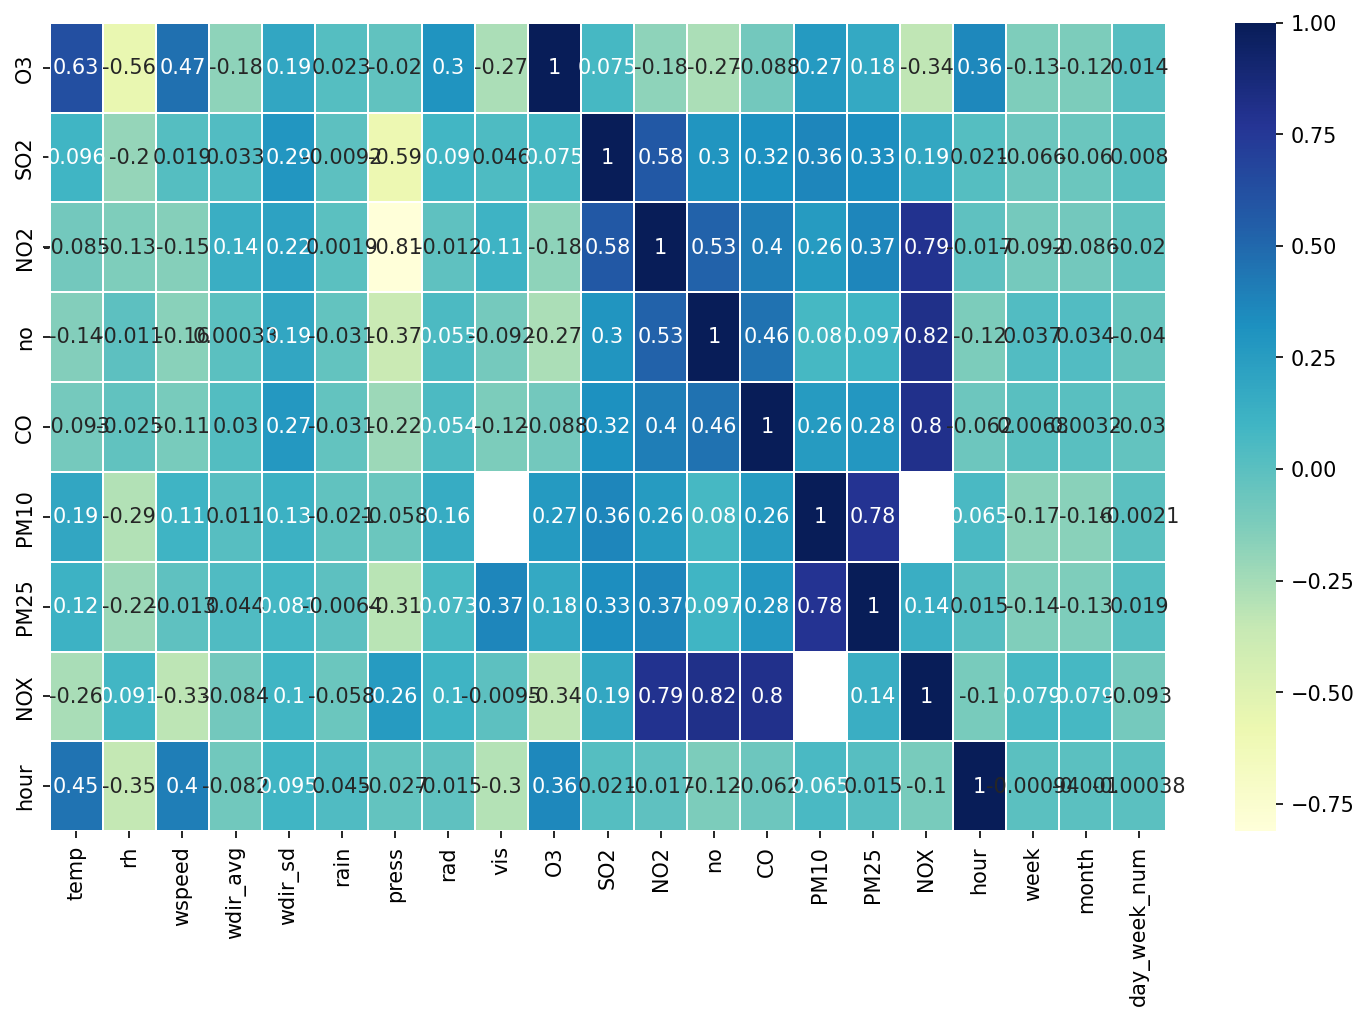

In [12]:
corrM = df.corr()
fig, ax = plt.subplots(figsize=(12, 7), dpi=150)
sns.heatmap(corrM[9:-3], annot=True, cmap="YlGnBu", linewidths=0.1,)

# Wind Rose

In [13]:
from windrose import WindroseAxes
import matplotlib.cm as cm
from math import pi

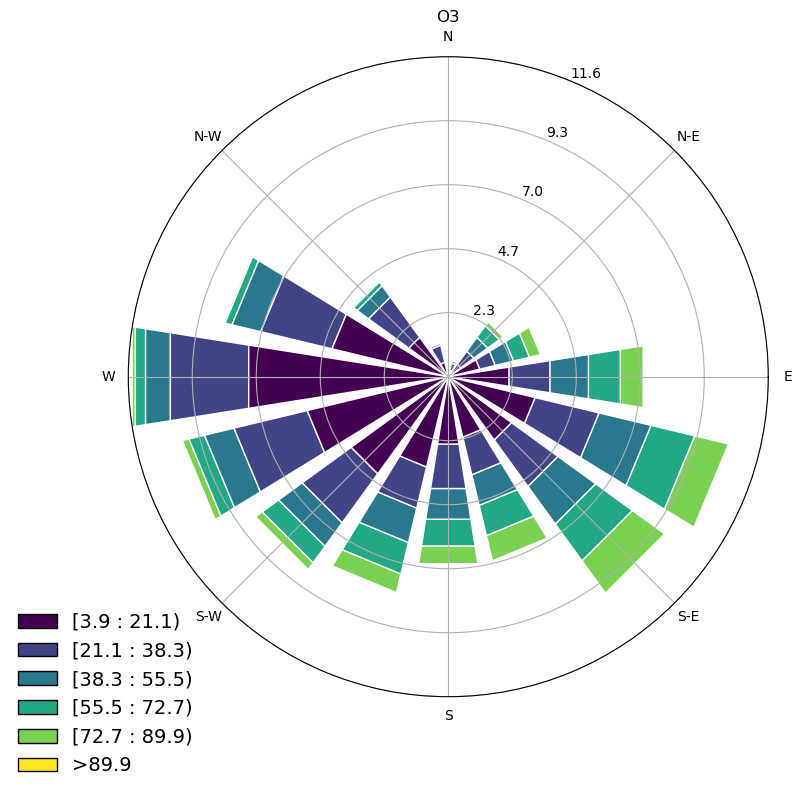

In [14]:
def wd_poll(dft, gas='NO2'):
    ax = WindroseAxes.from_ax()
    dft = dft[['wdir_avg', gas]].dropna()
    ax.bar(dft.wdir_avg, dft[gas], normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    ax.set_title(f'{gas}')
    plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.1, -0.1])
    fig = plt.gcf()
    fig.set_dpi(100)


wd_poll(df[df.region == 'Mexico'], gases[0])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

In [15]:
df.columns

Index(['time', 'region', 'temp', 'rh', 'wspeed', 'wdir_avg', 'wdir_sd', 'rain',
       'press', 'rad', 'vis', 'O3', 'SO2', 'NO2', 'no', 'CO', 'PM10', 'PM25',
       'NOX', 'hour', 'week', 'month', 'dayname', 'time_day', 'time_week',
       'time_month', 'day_week_num'],
      dtype='object')

<AxesSubplot:xlabel='time_day', ylabel='SO2'>

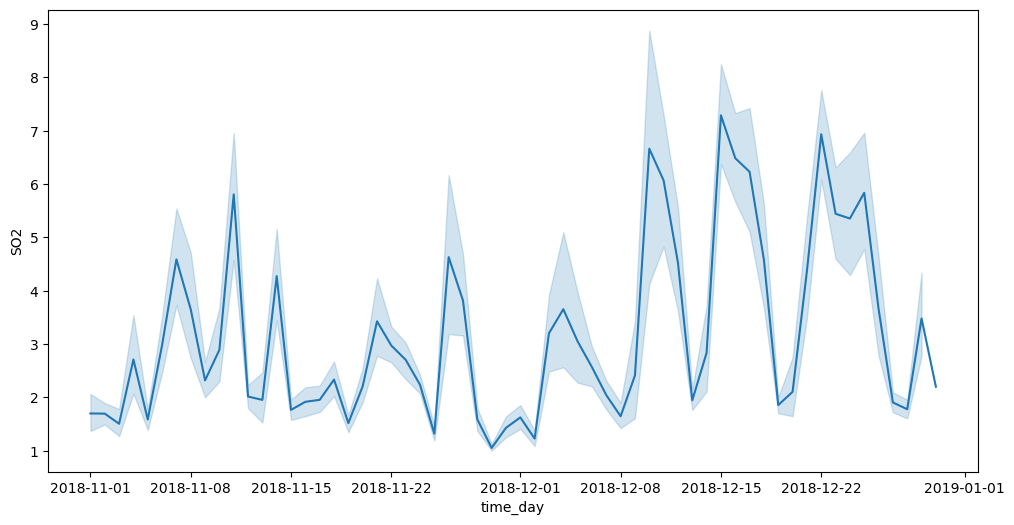

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=df[(df.region == 'Mexico') & df.time.between('2018-11-01', '2018-12-30')], x='time_day', y=gases[1], ax=ax)

In [17]:
df[(df.region == 'Mexico') & df.time.between('2018-11-01', '2018-12-30')].groupby('time_day').SO2.mean()

time_day
2018-11-01    1.698696
2018-11-02    1.695455
2018-11-03    1.505625
2018-11-04    2.710474
2018-11-05    1.585458
2018-11-06    2.978333
2018-11-07    4.587143
2018-11-08    3.650958
2018-11-09    2.318792
2018-11-10    2.891391
2018-11-11    5.805611
2018-11-12    2.015292
2018-11-13    1.953000
2018-11-14    4.273545
2018-11-15    1.765917
2018-11-16    1.917333
2018-11-17    1.954125
2018-11-18    2.334000
2018-11-19    1.518042
2018-11-20    2.208292
2018-11-21    3.426250
2018-11-22    2.971227
2018-11-23    2.704167
2018-11-24    2.237500
2018-11-25    1.319458
2018-11-26    4.629647
2018-11-27    3.814000
2018-11-28    1.588208
2018-11-29    1.052083
2018-11-30    1.429833
2018-12-01    1.624292
2018-12-02    1.227364
2018-12-03    3.202773
2018-12-04    3.653333
2018-12-05    3.048409
2018-12-06    2.566667
2018-12-07    2.041667
2018-12-08    1.646542
2018-12-09    2.411000
2018-12-10    6.661857
2018-12-11    6.066286
2018-12-12    4.525167
2018-12-13    1.944458
20

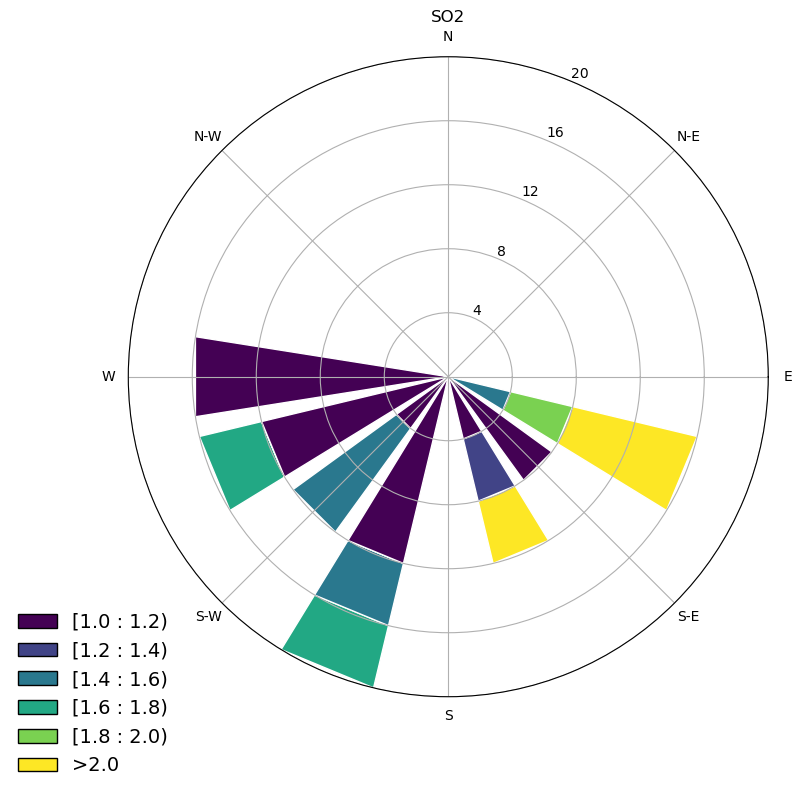

In [32]:
wd_poll(df[(df.region == 'Mexico') & df.time.between('2018-11-25', '2018-11-26')], gases[1])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

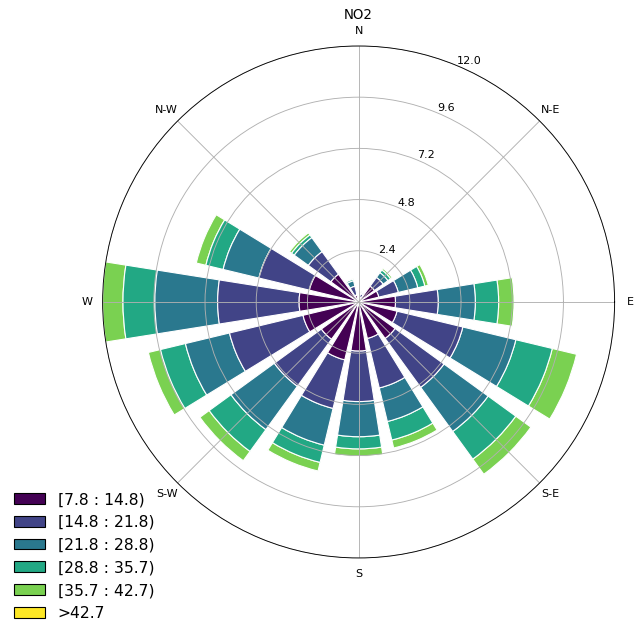

In [65]:
wd_poll(df[df.region == 'Mexico'], gases[2])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

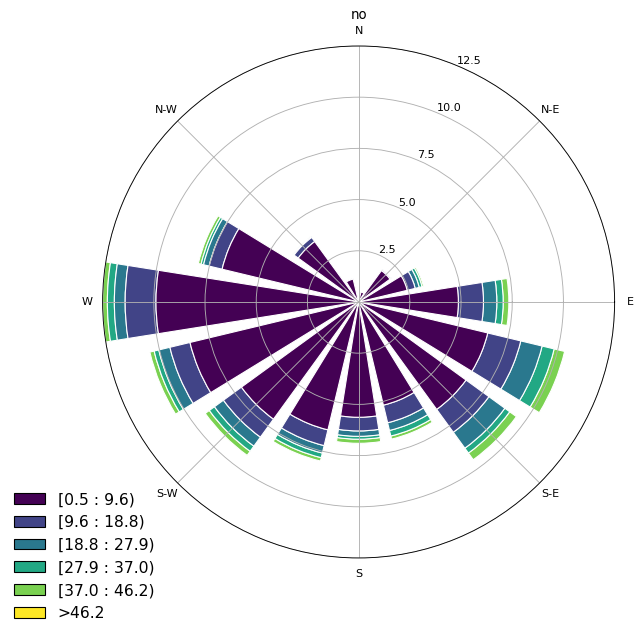

In [66]:
wd_poll(df[df.region == 'Mexico'], gases[3])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

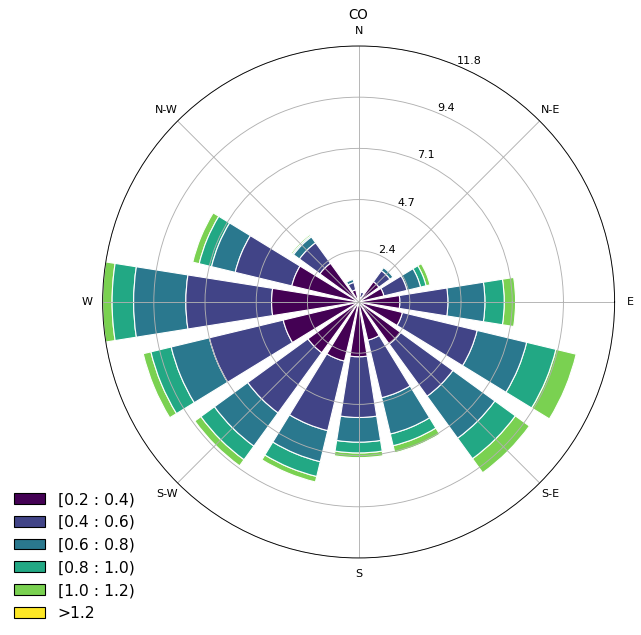

In [67]:
wd_poll(df[df.region == 'Mexico'], gases[4])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

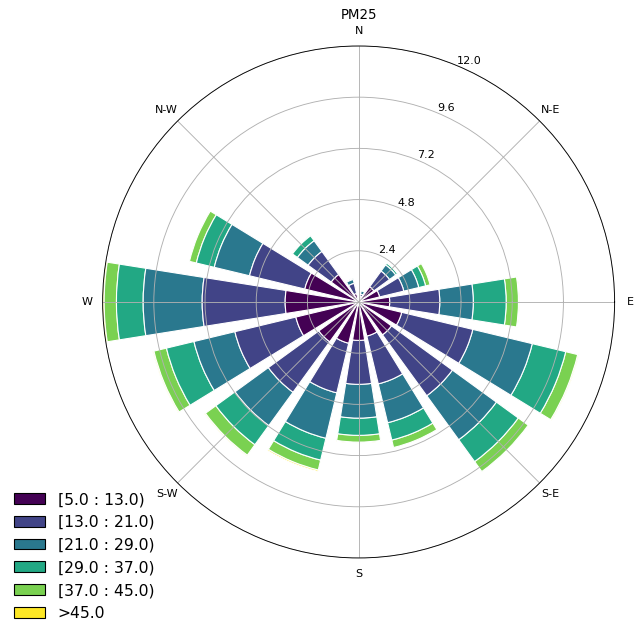

In [76]:
wd_poll(df[df.region == 'Mexico'], gases[6])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

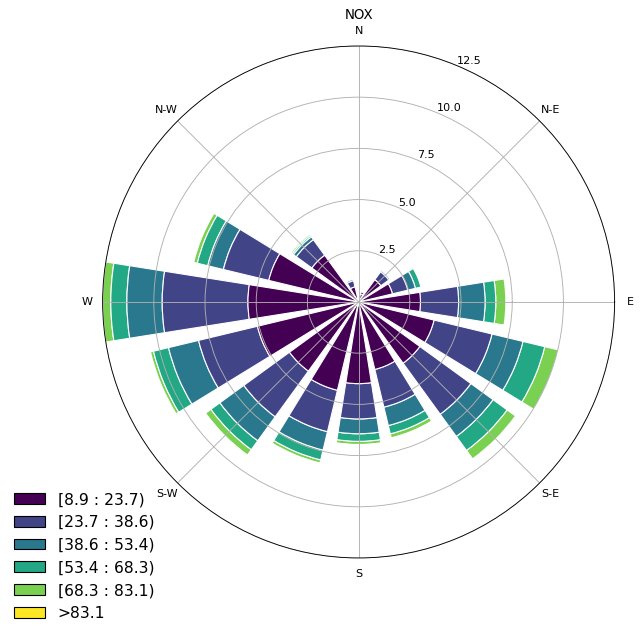

In [77]:
wd_poll(df[df.region == 'Mexico'], gases[7])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

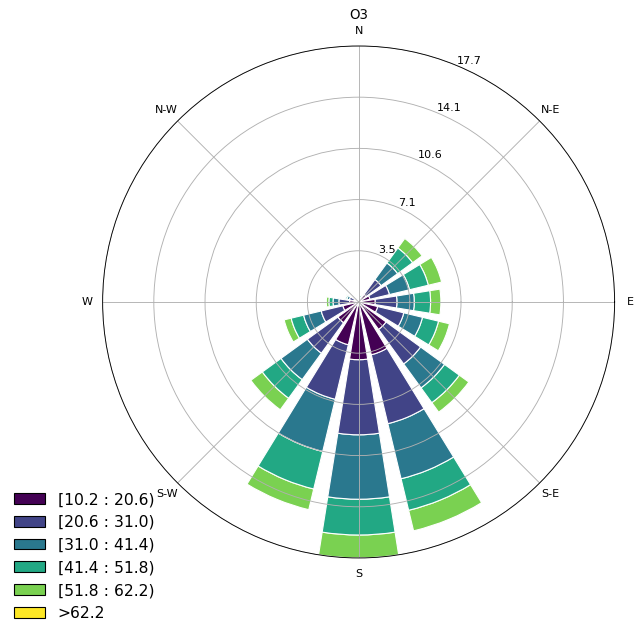

In [68]:
wd_poll(df[df.region == 'Morelia'], gases[0])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

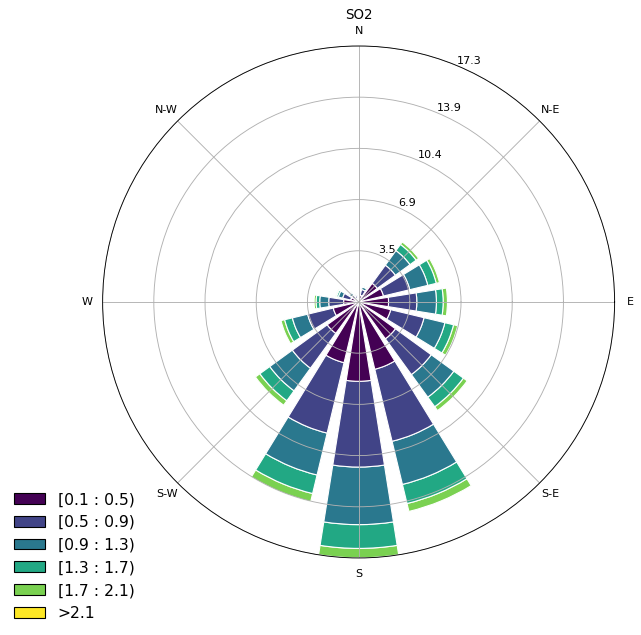

In [69]:
wd_poll(df[df.region == 'Morelia'], gases[1])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

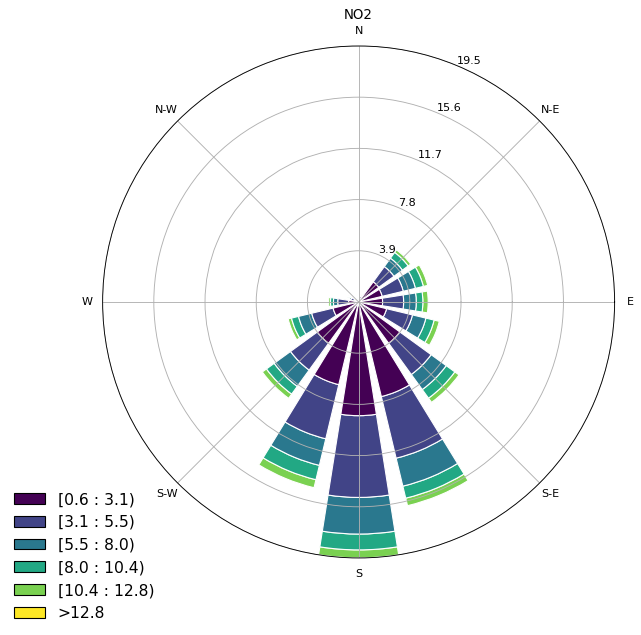

In [70]:
wd_poll(df[df.region == 'Morelia'], gases[2])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

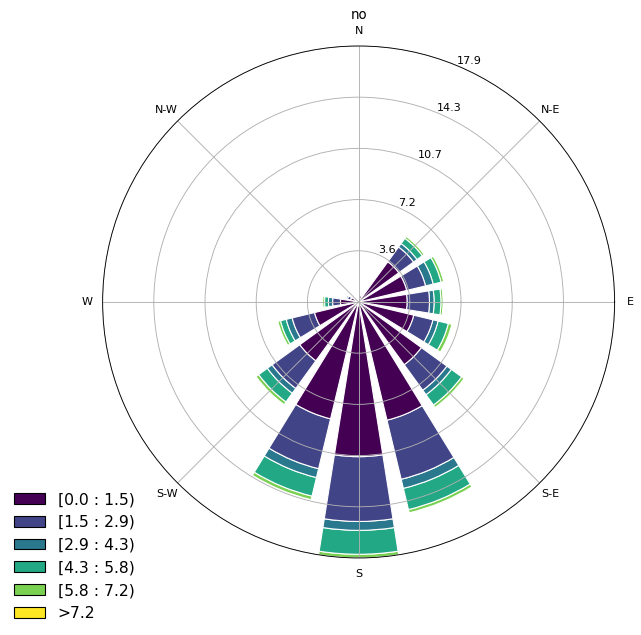

In [71]:
wd_poll(df[df.region == 'Morelia'], gases[3])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

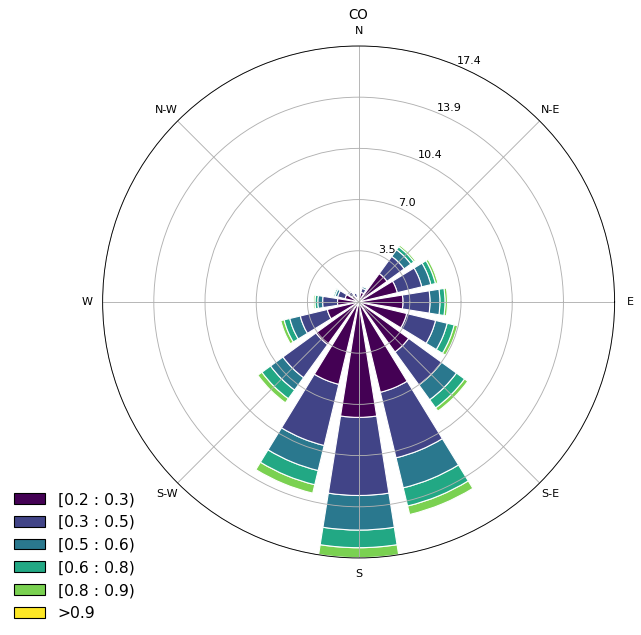

In [72]:
wd_poll(df[df.region == 'Morelia'], gases[4])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

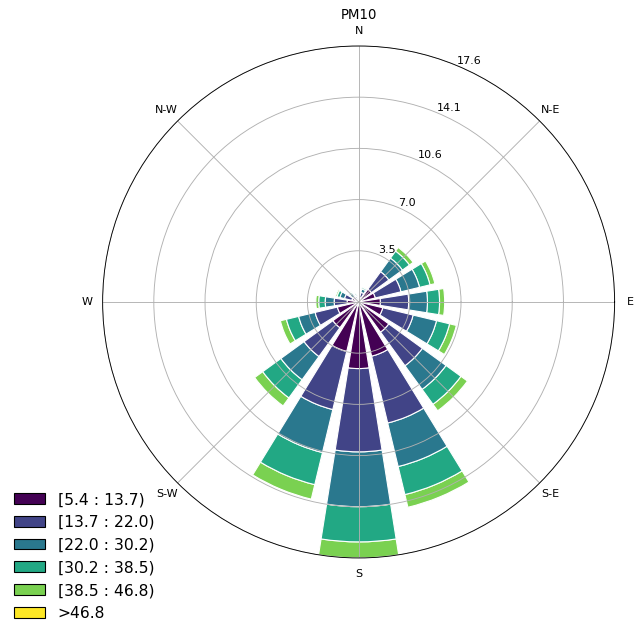

In [73]:
wd_poll(df[df.region == 'Morelia'], gases[5])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

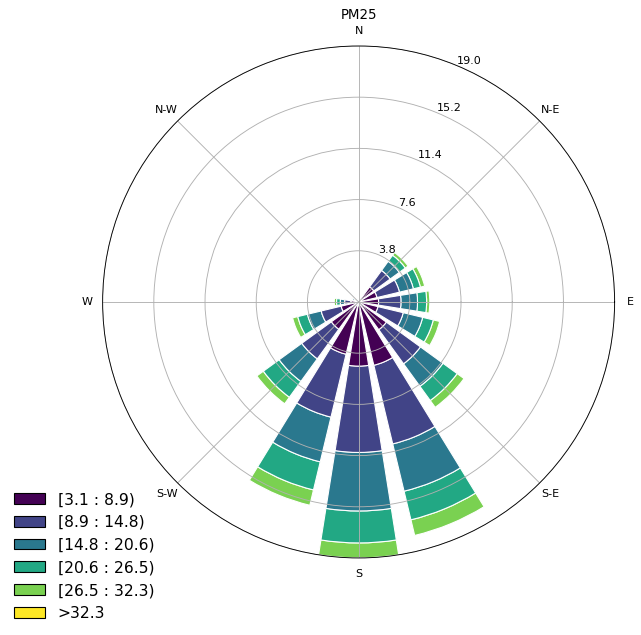

In [74]:
wd_poll(df[df.region == 'Morelia'], gases[6])
plt.legend(loc='lower left', frameon=False, bbox_to_anchor=[-0.2, -0.15], fontsize=14)

# 2D hist

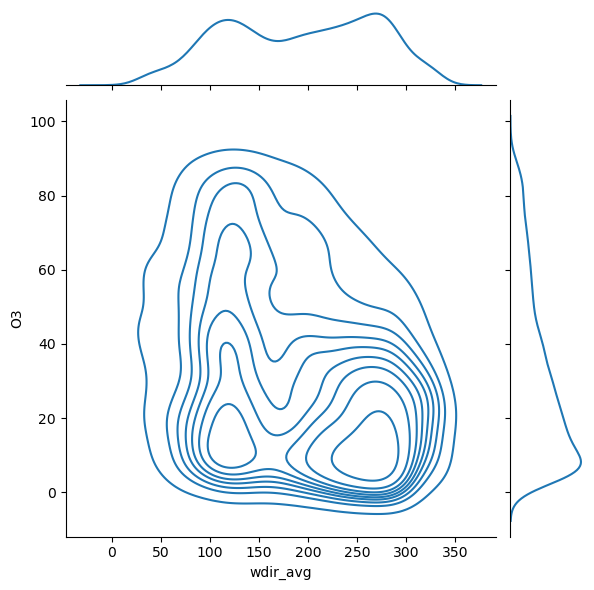

In [70]:
sns.jointplot(data=df[df.region=='Mexico'], x='wdir_avg', y=gases[0],  kind="kde")

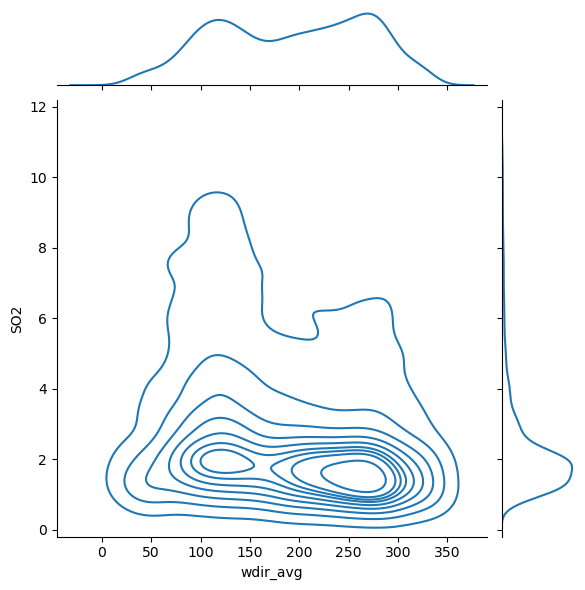

In [80]:
sns.jointplot(data=df[df.region=='Mexico'], x='wdir_avg', y=gases[1],  kind="kde")

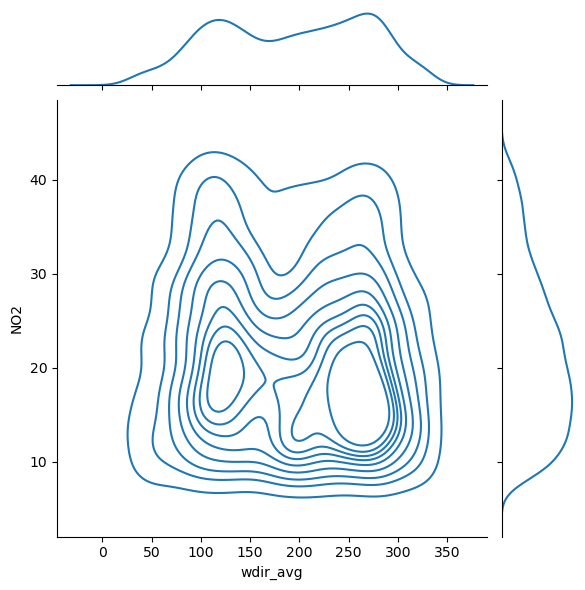

In [81]:
sns.jointplot(data=df[df.region=='Mexico'], x='wdir_avg', y=gases[2],  kind="kde")

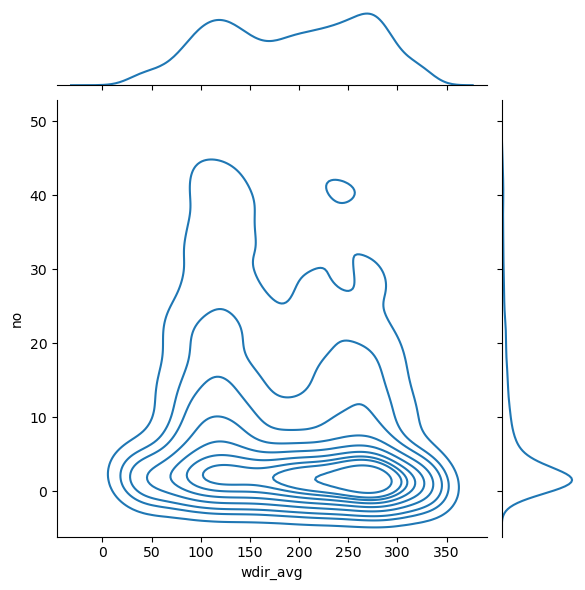

In [82]:
sns.jointplot(data=df[df.region=='Mexico'], x='wdir_avg', y=gases[3],  kind="kde")

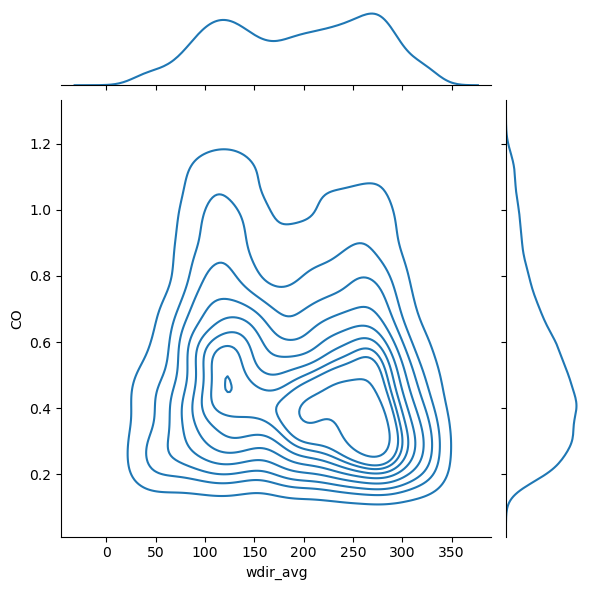

In [83]:
sns.jointplot(data=df[df.region=='Mexico'], x='wdir_avg', y=gases[4],  kind="kde")

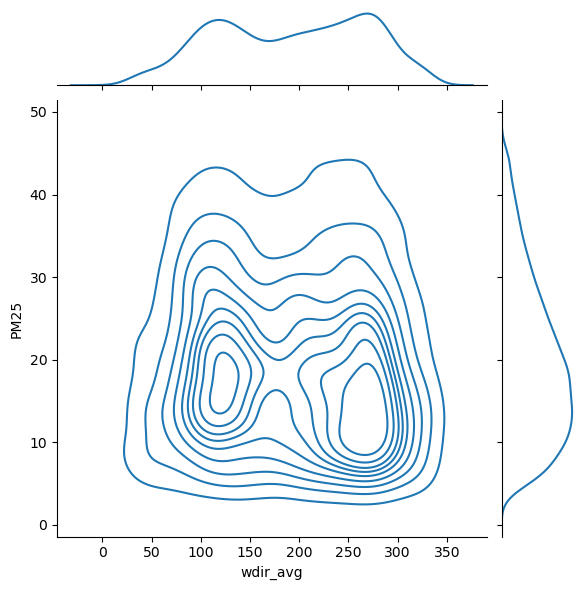

In [85]:
sns.jointplot(data=df[df.region=='Mexico'], x='wdir_avg', y=gases[6],  kind="kde")

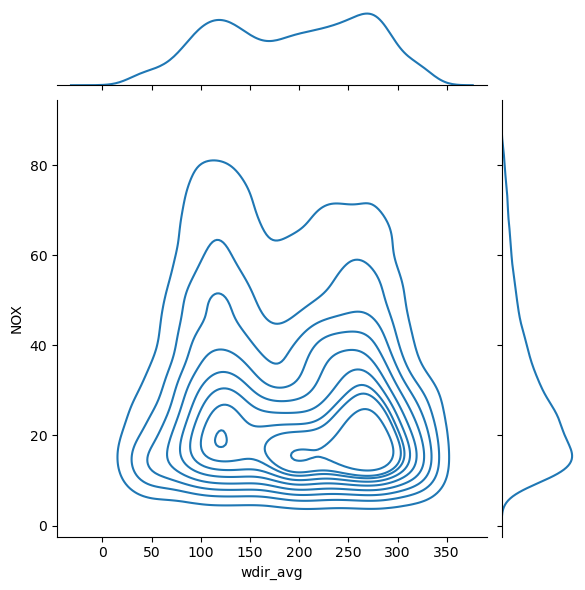

In [86]:
sns.jointplot(data=df[df.region=='Mexico'], x='wdir_avg', y=gases[7],  kind="kde")

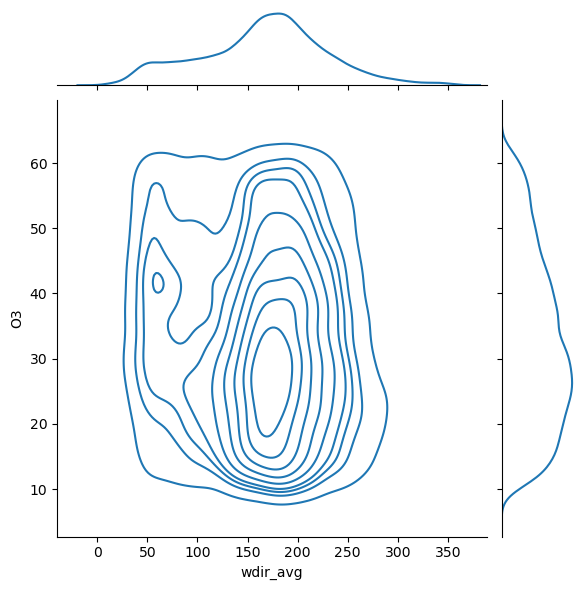

In [87]:
sns.jointplot(data=df[df.region=='Morelia'], x='wdir_avg', y=gases[0],  kind="kde")

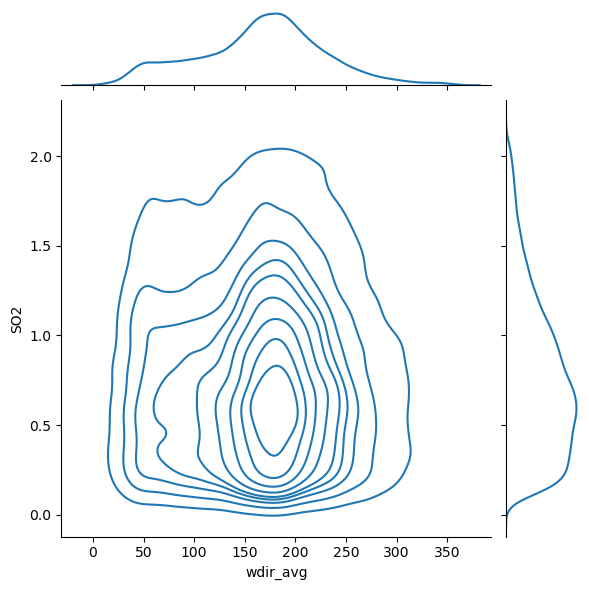

In [88]:
sns.jointplot(data=df[df.region=='Morelia'], x='wdir_avg', y=gases[1],  kind="kde")

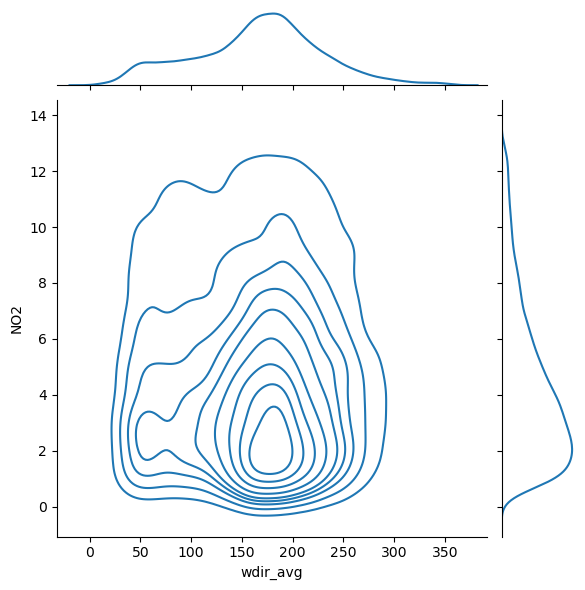

In [89]:
sns.jointplot(data=df[df.region=='Morelia'], x='wdir_avg', y=gases[2],  kind="kde")

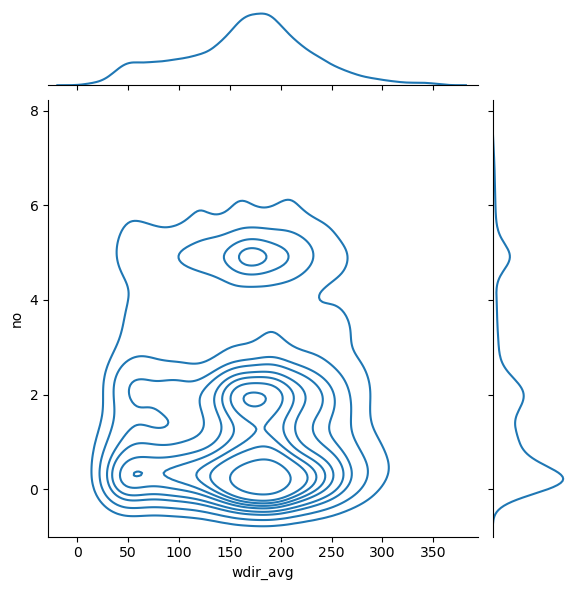

In [90]:
sns.jointplot(data=df[df.region=='Morelia'], x='wdir_avg', y=gases[3],  kind="kde")

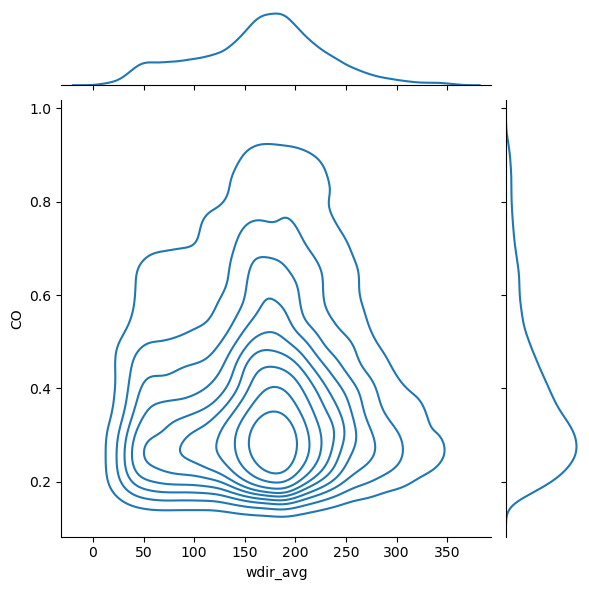

In [91]:
sns.jointplot(data=df[df.region=='Morelia'], x='wdir_avg', y=gases[4],  kind="kde")

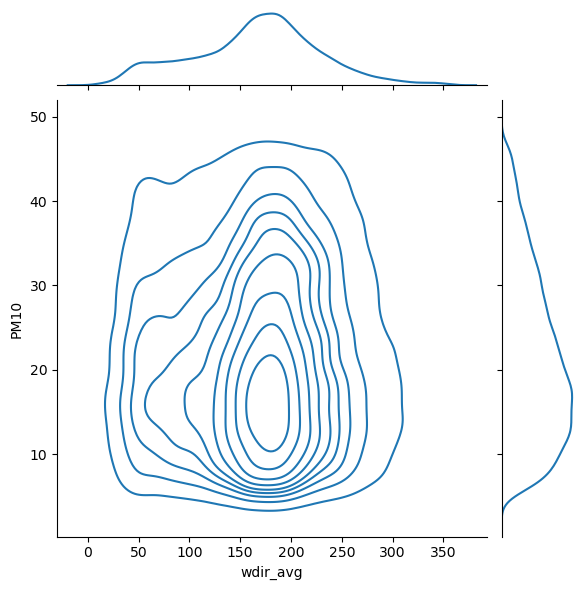

In [92]:
sns.jointplot(data=df[df.region=='Morelia'], x='wdir_avg', y=gases[5],  kind="kde")

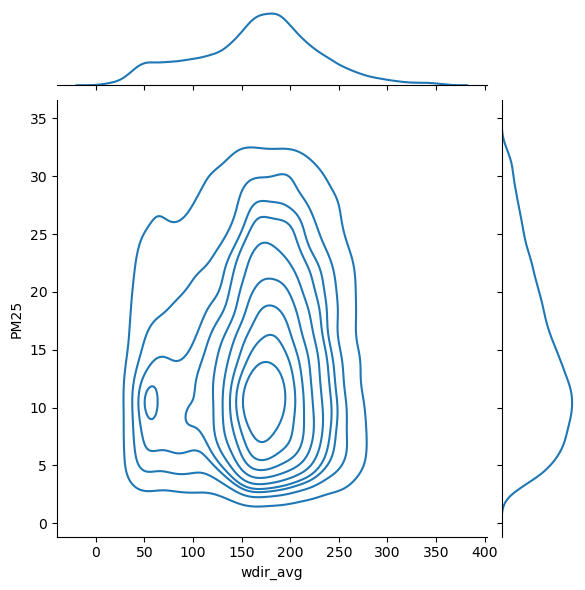

In [93]:
sns.jointplot(data=df[df.region=='Morelia'], x='wdir_avg', y=gases[6],  kind="kde")